# Discussion


## How did you preprocess this dataset ?
我嘗試用現有的資料做了各種運算，包含:
1. 對Close Price, Open Price, High Price, Low Price, Volume取log以及其他前處理
2. 今天的Price與n天前Price的差距
3. Price相對前一天的變化的百分比
4. Close Price前n天漲跌的排列方式
5. Price在n天內漲/跌了幾次
6. Price連續漲/跌的天數
7. n天內平均漲/跌的幅度
8. Close Price震盪平率
9. Close Price的漲跌連續變化次數
10. Close Price的漲跌連續變化次數 && 當天漲或跌
11. Open Price與Close Price的差距
12. 日期
    
不過沒有全部用上

## Which classifier reaches the highest classification accuracy in this dataset ?

Logistic Regression的`test accuracy`最高: 0.595，但它的`train accuracy`只有0.556

RandomForestClassifiery則是`training accuracy`(0.591)，`test accuracy`(0.583) 都很高，我推斷是它比較準確

### Why ?

因為這次預測的是漲或跌(分類)，而不是漲或跌的幅度(數值)，因此比較適合用RandomForestClassifiery來做

###  Can this result remain if the dataset is different ?

可以

## How did you improve your classifiers ?

做許多資料的前處理，挑選合適的資料放進model來train，挑選合適的參數給model使用。

詳細來說的話:

**Logistic Regression**

*   random_state = 1012
*   penalty = 'l2'
*   C = 1e6
*   max_iter = 85
*   class_weight = {0 : 0.51, 1 : 0.5}

這裡我故意把`max_iter`調低，雖然會跳出 `ConvergenceWarning: lbfgs failed to converge` 的warning，但test的結果反而變準。

這裡我把0的`class_weight`稍微調高0.01，accuracy比原本weight都一樣還高。再調更高accuracy又會降低了。


---

**Neural Network**

努力試著找到一個深度, `epochs`, `batch_size`比較合適的數量


---


**RandomForestClassifier**

`max_depth`深於5就開始出現overfitting的現象，淺於5則會underfitting

`n_estimators`, `min_samples_split` 也都是慢慢試出來的結果


# 資料前處理

In [0]:
import numpy as np
import pandas as pd

dfs = [pd.read_csv('train.csv'), pd.read_csv('test.csv')]
dfs[0].head()
print(dfs[0].isnull().sum())

Date           0
Open Price     0
Close Price    0
High Price     0
Low Price      0
Volume         0
dtype: int64


將training data set與test data set讀入，每個欄位的資料都是完整的，不用填補缺失值

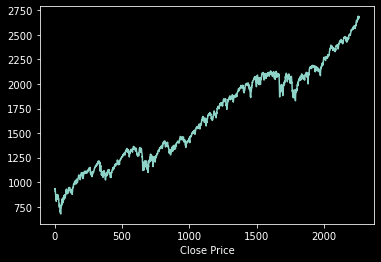

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('dark_background')
plt.xlabel('Close Price')
plt.plot(dfs[0]['Close Price'])

目標是要預測`Close Price`的漲跌



## 隔日Close Price漲跌

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


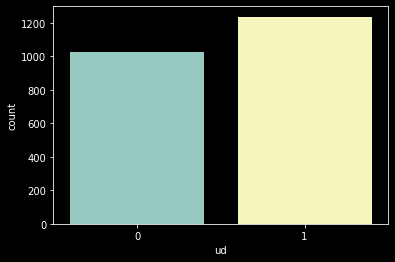

In [0]:
def pn2bi(num):
    return ((np.sign(num) + 1) // 2).astype(int)

for df in dfs:
    df['Tmr'] = df['Close Price'].shift(-1)
    df['Tmr'][len(df['Tmr']) - 1] = 0
    df['ud'] = pn2bi(df['Tmr'] - df['Close Price'])

g = sns.countplot(x = 'ud', data = dfs[0])

`Tmr`是向前位移一格的`Close Price`，也就是隔日的`Close Price`

將`Tmr`與`Close Price`相減，得到隔日`Close Price`是否漲，作為training的答案

可以看出漲比跌的情況略多一些

## Close Price, Open Price, High Price, Low Price, Volume

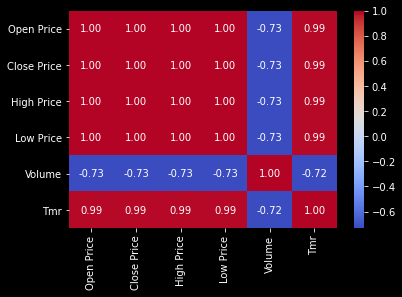

In [0]:
sns.heatmap(dfs[0][['Open Price','Close Price', 'High Price','Low Price','Volume','Tmr']].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

這裡的相關係數可以看出`Open Price`, `Close Price`, `High Price`, `Low Price` 關聯度很大

(array([ 38., 799., 740., 285., 159., 103.,  73.,  37.,  23.,   7.]),
 array([5.18158400e+08, 1.37835260e+09, 2.23854679e+09, 3.09874099e+09,
        3.95893518e+09, 4.81912938e+09, 5.67932357e+09, 6.53951777e+09,
        7.39971196e+09, 8.25990616e+09, 9.12010035e+09]),
 <a list of 10 Patch objects>)

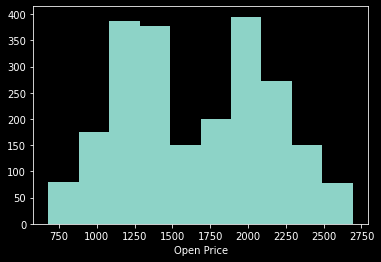

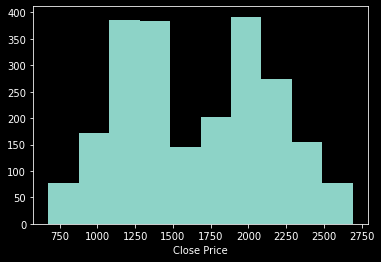

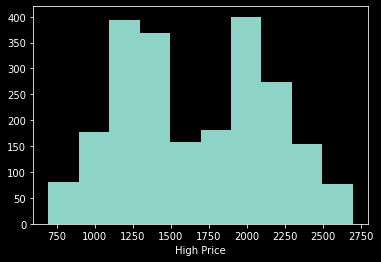

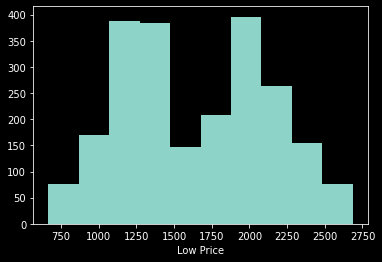

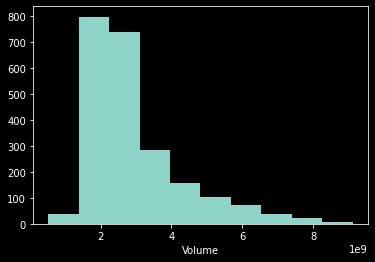

In [0]:
plt.figure(1)
plt.xlabel('Open Price')
plt.hist(dfs[0]['Open Price'])

plt.figure(2)
plt.xlabel('Close Price')
plt.hist(dfs[0]['Close Price'])

plt.figure(3)
plt.xlabel('High Price')
plt.hist(dfs[0]['High Price'])

plt.figure(4)
plt.xlabel('Low Price')
plt.hist(dfs[0]['Low Price'])

plt.figure(5)
plt.xlabel('Volume')
plt.hist(dfs[0]['Volume'])

這裡可以看出`Volume`與其他資料欄位的值相差很大，因此做normalize

`Volume`值大多集中在前面，取log來讓資料不那麼偏移

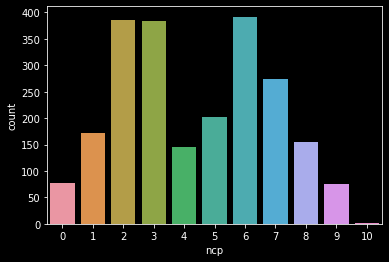

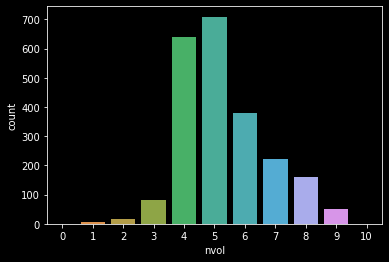

In [0]:
def normalize(dataset):
    dataNorm=((dataset-dataset.min())/(dataset.max()-dataset.min()))
    return dataNorm

for df in dfs:
    df["nop"] = (normalize(df["Open Price"]) * 10).astype(int)
    df["ncp"] = (normalize(df["Close Price"]) * 10).astype(int)
    df["nhp"] = (normalize(df["High Price"]) * 10).astype(int)
    df["nlp"] = (normalize(df["Low Price"]) * 10).astype(int)
    df["nvol"] = (normalize(np.log(df["Volume"])) * 10).astype(int)

plt.figure(1)
plt.xlabel('Normalized Close Price')
g = sns.countplot(x = 'ncp', data = dfs[0])

plt.figure(2)
plt.xlabel('Normalized Volume')
g = sns.countplot(x = 'nvol', data = dfs[0])

normalize過後順便將資料分為十個等分

## 今天的Price與n天前Price的差距

(array([   3.,   17.,   69.,  266., 1357.,  428.,   94.,   21.,    6.,
           3.]), array([-30.0973408 , -23.57302035, -17.0486999 , -10.52437946,
         -4.00005901,   2.52426144,   9.04858189,  15.57290234,
         22.09722278,  28.62154323,  35.14586368]), <a list of 10 Patch objects>)

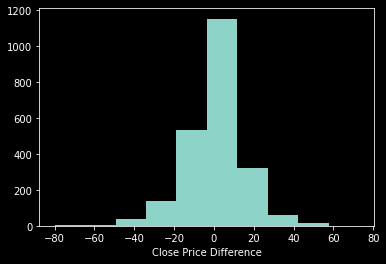

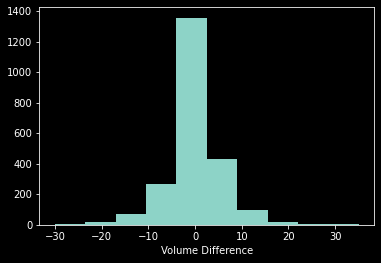

In [0]:
def get_diff(data, days):
    yesterday = data.shift(days)
    yesterday[0:days] = yesterday[days]
    return data - yesterday

for df in dfs:
    df['rdop'] = get_diff(df['Open Price'], 1)
    df['rdcp'] = get_diff(df['Close Price'], 1)
    df['rdhp'] = get_diff(df['High Price'], 1)
    df['rdlp'] = get_diff(df['Low Price'], 1)
    df['rdvol'] = get_diff(df['Volume'], 1) / 10e7

plt.figure(1)
plt.xlabel('Close Price Difference')
plt.hist(dfs[0]['rdcp'])

plt.figure(2)
plt.xlabel('Volume Difference')
plt.hist(dfs[0]['rdvol'])

這裡算出`Open Price`, `Close Price`, `High Price`, `Low Price`, `Volume`相對於前一天的變化

資料大多集中在0附近，取log讓資料平均分散

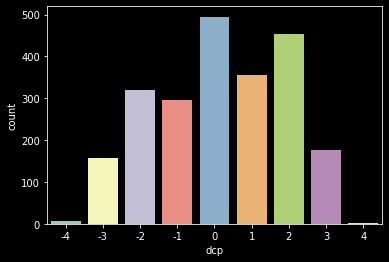

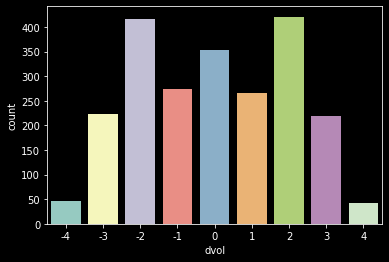

In [0]:
def pnlog(num):
    if abs(num) <= 1:
        return 0
    else:
        return np.log(abs(num)) * np.sign(num)

for df in dfs:
    df['dop'] = df['rdop'].apply(pnlog).astype(int)
    df['dcp'] = df['rdcp'].apply(pnlog).astype(int)
    df['dhp'] = df['rdhp'].apply(pnlog).astype(int)
    df['dlp'] = df['rdlp'].apply(pnlog).astype(int)
    df['dvol'] = (df['rdvol'] * 4).apply(pnlog).astype(int)

plt.figure(1)
plt.xlabel('Log Close Price Difference')
g = sns.countplot(x = 'dcp', data = dfs[0])

plt.figure(2)
plt.xlabel('Log Volume Difference')
g = sns.countplot(x = 'dvol', data = dfs[0])

因為很多資料靠近0，直接取log會出現`-inf`，因此將絕對值小於1的值都算做0

In [0]:
for df in dfs:
    for i in range(2,7):
        df['rpre' + str(i)] = get_diff(df['Close Price'], i)
        df['pre' + str(i)] = df['rpre' + str(i)].apply(pnlog).astype(int)

這裡是將`Close Price`向對於前2-7天的變化都算出來，並按照前面的方式作處理

## Price相對前一天的變化的百分比

(array([   2.,    8.,   26.,  156., 1054.,  888.,  103.,   21.,    4.,
           2.]),
 array([-6.65844636, -5.29949204, -3.94053771, -2.58158339, -1.22262906,
         0.13632527,  1.49527959,  2.85423392,  4.21318824,  5.57214257,
         6.93109689]),
 <a list of 10 Patch objects>)

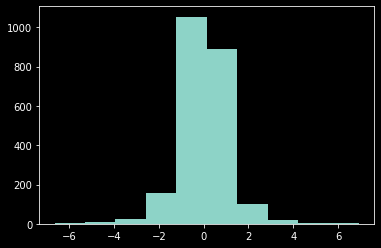

In [0]:
def get_percent(dif, data):
    yesterday = data.shift(1)
    yesterday[0] = yesterday[1]
    return dif / yesterday * 100

for df in dfs:
    df['pdop'] = get_percent(df['rdop'], df['Close Price'])
    df['pdcp'] = get_percent(df['rdcp'], df['Open Price'])
    df['pdhp'] = get_percent(df['rdhp'], df['High Price'])
    df['pdlp'] = get_percent(df['rdlp'], df['Low Price'])

plt.hist(dfs[0]['pdcp'])

`Open Price`, `Close Price`, `High Price`, `Low Price`變化百分比的分布，一樣大部分集中在0，因此用前面的方式取log做處理

(array([  1.,  57., 257., 304., 235., 567., 435., 342.,  64.,   2.]),
 array([-5. , -4.1, -3.2, -2.3, -1.4, -0.5,  0.4,  1.3,  2.2,  3.1,  4. ]),
 <a list of 10 Patch objects>)

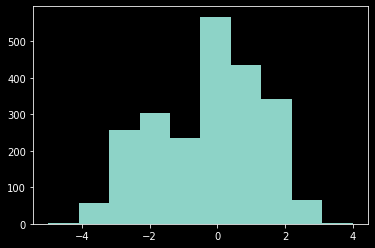

In [0]:
for df in dfs:
    df['pdop'] = ((get_percent(df['rdop'], df['Close Price']) * 10).apply(pnlog) * 10).astype(int) // 10
    df['pdcp'] = ((get_percent(df['rdcp'], df['Open Price']) * 10).apply(pnlog) * 10).astype(int) // 10
    df['pdhp'] = ((get_percent(df['rdhp'], df['High Price']) * 10).apply(pnlog) * 10).astype(int) // 10
    df['pdlp'] = ((get_percent(df['rdlp'], df['Low Price']) * 10).apply(pnlog) * 10).astype(int) // 10

plt.hist(dfs[0]['pdcp'])

In [0]:
# for df in dfs:
#     df.loc[ df['pdop'] > 60, 'pdop'] = 60
#     df.loc[ df['pdop'] < -60, 'pdop'] = -60
#     df['pdop'] = df['pdop'] // 10
#     df.loc[ df['pdcp'] > 60, 'pdcp'] = 60
#     df.loc[ df['pdcp'] < -60, 'pdcp'] = -60
#     df['pdcp'] = df['pdcp'] // 10
#     df.loc[ df['pdhp'] > 60, 'pdhp'] = 60
#     df.loc[ df['pdhp'] < -60, 'pdhp'] = -60
#     df['pdhp'] = df['pdhp'] // 10
#     df.loc[ df['pdlp'] > 60, 'pdlp'] = 60
#     df.loc[ df['pdlp'] < -60, 'pdlp'] = -60
#     df['pdlp'] = df['pdlp'] // 10

#     plt.hist(dfs[0]['pdcp'])

上面的cell是我自己試的另一種處理方式，結果不如預期，因此沒使用

## Close Price前n天漲跌的排列方式

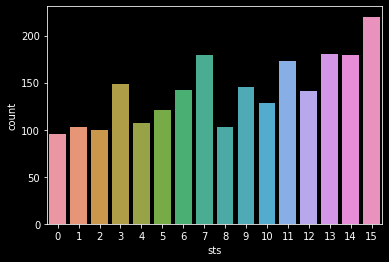

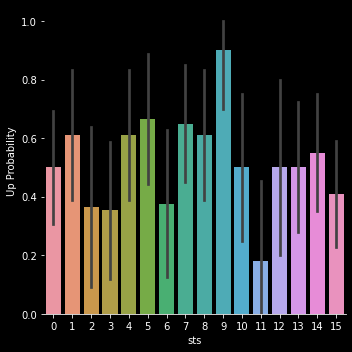

In [0]:
def get_sts(df, days):
    sts = np.zeros(df.shape[0])
    for i in range(days, df.shape[0]):
        for j in range(1, days+1):
            sts[i] += pn2bi(df['rdop'][i-j]) * (2**(days-j))
    return sts.astype(int)

for df in dfs:
    df['sts'] = get_sts(df, 4)

g = sns.countplot(x = 'sts', data = dfs[0])

g = sns.catplot(x="sts",y="ud",data=df,kind="bar")
g.despine(left=True)
g = g.set_ylabels("Up Probability")

`sts`紀錄的是前n天`Close Price`漲跌的排列方式，這裡取n=4，總共16種排列方式

## Price在n天內漲/跌了幾次

'oup3','cup3','hup3','lup3','odn3','cdn3','hdn3','ldn3'
dfs[0]['oup3']
dfs[0]['cup3']
dfs[0]['hup3']
dfs[0]['lup3']
dfs[0]['odn3']
dfs[0]['cdn3']
dfs[0]['hdn3']
dfs[0]['ldn3']
'oup5','cup5','hup5','lup5','odn5','cdn5','hdn5','ldn5'
dfs[0]['oup5']
dfs[0]['cup5']
dfs[0]['hup5']
dfs[0]['lup5']
dfs[0]['odn5']
dfs[0]['cdn5']
dfs[0]['hdn5']
dfs[0]['ldn5']
'oup6','cup6','hup6','lup6','odn6','cdn6','hdn6','ldn6'
dfs[0]['oup6']
dfs[0]['cup6']
dfs[0]['hup6']
dfs[0]['lup6']
dfs[0]['odn6']
dfs[0]['cdn6']
dfs[0]['hdn6']
dfs[0]['ldn6']
'oup7','cup7','hup7','lup7','odn7','cdn7','hdn7','ldn7'
dfs[0]['oup7']
dfs[0]['cup7']
dfs[0]['hup7']
dfs[0]['lup7']
dfs[0]['odn7']
dfs[0]['cdn7']
dfs[0]['hdn7']
dfs[0]['ldn7']


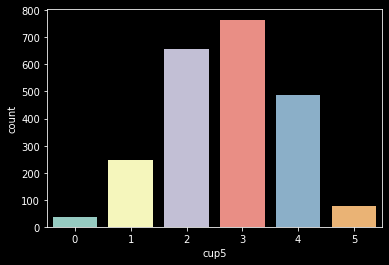

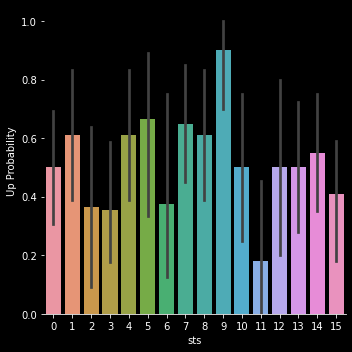

In [0]:
def cntup(dif, days):
    cnt = np.zeros(len(dif))
    cnt[0] = pn2bi(dif[0])
    for i in range(1, days):
        cnt[i] = cnt[i-1] + pn2bi(dif[i])

    for i in range(days, len(dif)):
        cnt[i] = cnt[i-1] + pn2bi(dif[i])
        cnt[i] = cnt[i] - pn2bi(dif[i - days])
    return cnt.astype(int)

def cntdn(dif, days):
    cnt = np.zeros(len(dif))
    cnt[0] = pn2bi(dif[0]) - 1
    for i in range(1, days):
        cnt[i] = cnt[i-1] + (pn2bi(dif[i]) - 1)

    for i in range(days, len(dif)):
        cnt[i] = cnt[i-1] + (pn2bi(dif[i]) - 1)
        cnt[i] = cnt[i] - (pn2bi(dif[i - days]) - 1)
    
    cnt = abs(cnt)
    return cnt.astype(int)

def gen_cnt(days):
    for df in dfs:
        df['oup' + str(days)] = cntup(df['rdop'], days)
        df['odn' + str(days)] = cntdn(df['rdop'], days)
        df['cup' + str(days)] = cntup(df['rdcp'], days)
        df['cdn' + str(days)] = cntdn(df['rdcp'], days)
        df['hup' + str(days)] = cntup(df['rdhp'], days)
        df['hdn' + str(days)] = cntdn(df['rdhp'], days)
        df['lup' + str(days)] = cntup(df['rdlp'], days)
        df['ldn' + str(days)] = cntdn(df['rdlp'], days)
    print(f"\'oup{days}\',\'cup{days}\',\'hup{days}\',\'lup{days}\',\'odn{days}\',\'cdn{days}\',\'hdn{days}\',\'ldn{days}\'", )
    print(f"dfs[0][\'oup{days}\']")
    print(f"dfs[0][\'cup{days}\']")
    print(f"dfs[0][\'hup{days}\']")
    print(f"dfs[0][\'lup{days}\']")
    print(f"dfs[0][\'odn{days}\']")
    print(f"dfs[0][\'cdn{days}\']")
    print(f"dfs[0][\'hdn{days}\']")
    print(f"dfs[0][\'ldn{days}\']")

gen_cnt(3)
gen_cnt(5)
gen_cnt(6)
gen_cnt(7)

g = sns.countplot(x = 'cup5', data = dfs[0])

g = sns.catplot(x="sts",y="ud",data=df,kind="bar")
g.despine(left=True)
g = g.set_ylabels("Up Probability")

這裡挑選了n=3, 5, 6, 7來計算`Open Price`, `Close Price`, `High Price`, `Low Price`, `Volume`在n天內漲/跌了幾次

## Price連續漲/跌的天數

In [0]:
def streakup(dif):
    stk = np.zeros(len(dif))
    stk[0] = dif[0]
    for i in range(1, len(dif)):
        if dif[i] >= 0:
            stk[i] = stk[i-1] + 1
        else:
            stk[i] = 0
    return stk.astype(int)

def streakdn(dif):
    stk = np.zeros(len(dif))
    stk[0] = dif[0]
    for i in range(1, len(dif)):
        if dif[i] <= 0:
            stk[i] = stk[i-1] + 1
        else:
            stk[i] = 0
    return stk.astype(int)

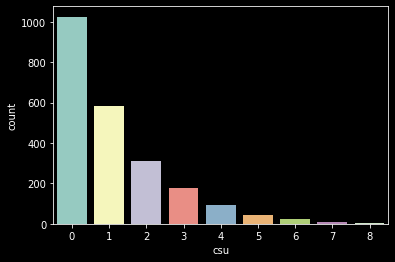

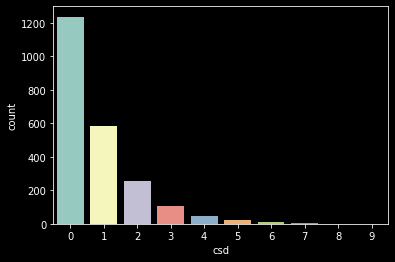

In [0]:
for df in dfs:
    df['osu'] = streakup(df['rdop'])
    df['osd'] = streakdn(df['rdop'])
    df['csu'] = streakup(df['rdcp'])
    df['csd'] = streakdn(df['rdcp'])
    df['hsu'] = streakup(df['rdhp'])
    df['hsd'] = streakdn(df['rdhp'])
    df['lsu'] = streakup(df['rdlp'])
    df['lsd'] = streakdn(df['rdlp'])

# 'osu','csu','hsu','lsu','osd','csd','hsd','lsd'

plt.figure(1)
g = sns.countplot(x = 'csu', data = dfs[0])
plt.figure(2)
g = sns.countplot(x = 'csd', data = dfs[0])

計算`Open Price`, `Close Price`, `High Price`, `Low Price`, `Volume`連續漲/跌了幾天

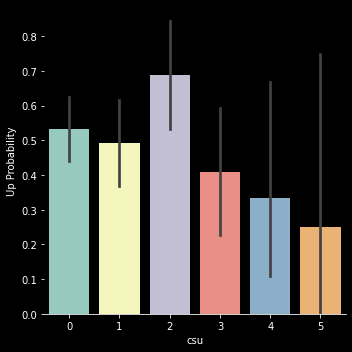

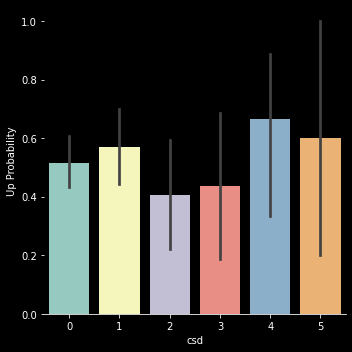

In [0]:
for df in dfs:
    df.loc[ df['osu'] > 5, 'osu'] = 5
    df.loc[ df['csu'] > 5, 'csu'] = 5
    df.loc[ df['hsu'] > 5, 'hsu'] = 5
    df.loc[ df['lsu'] > 5, 'lsu'] = 5
    df.loc[ df['osd'] > 5, 'osd'] = 5
    df.loc[ df['csd'] > 5, 'csd'] = 5
    df.loc[ df['hsd'] > 5, 'hsd'] = 5
    df.loc[ df['lsd'] > 5, 'lsd'] = 5

g = sns.catplot(x="csu",y="ud",data=df,kind="bar")
g.despine(left=True)
g = g.set_ylabels("Up Probability")

g = sns.catplot(x="csd",y="ud",data=df,kind="bar")
g.despine(left=True)
g = g.set_ylabels("Up Probability")

因為超過連續漲/跌超過5天的次數都很少，因此將`>=5`天全部歸為一類

## n天內平均漲/跌的幅度

'aco3','acc3','ach3','acl3'
dfs[0]['aco3']
dfs[0]['acc3']
dfs[0]['ach3']
dfs[0]['acl3']
'aco7','acc7','ach7','acl7'
dfs[0]['aco7']
dfs[0]['acc7']
dfs[0]['ach7']
dfs[0]['acl7']
'aco14','acc14','ach14','acl14'
dfs[0]['aco14']
dfs[0]['acc14']
dfs[0]['ach14']
dfs[0]['acl14']
'aco15','acc15','ach15','acl15'
dfs[0]['aco15']
dfs[0]['acc15']
dfs[0]['ach15']
dfs[0]['acl15']
'aco30','acc30','ach30','acl30'
dfs[0]['aco30']
dfs[0]['acc30']
dfs[0]['ach30']
dfs[0]['acl30']


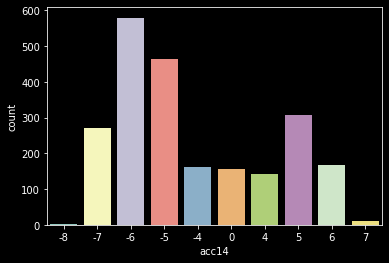

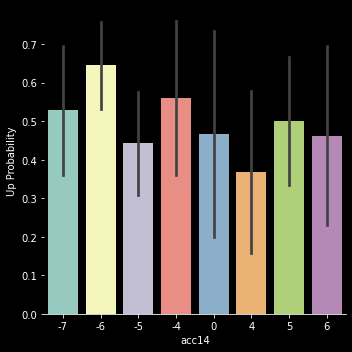

In [0]:
def accum(pct, days):
    accum = np.zeros(len(pct))
    accum[0] = pct[0]
    for i in range(1, days):
        accum[i] = accum[i-1] + pct[i]

    for i in range(days, len(pct)):
        accum[i] = accum[i-1] + pct[i]
        accum[i] = accum[i] - pct[i - days]
        
    return accum

def gen_accum(days):
    for df in dfs:
        df['aco' + str(days)] = accum(df['pdop'], days)
        df['acc' + str(days)] = accum(df['pdcp'], days)
        df['ach' + str(days)] = accum(df['pdhp'], days)
        df['acl' + str(days)] = accum(df['pdlp'], days)

        df['aco' + str(days)] = (df['aco' + str(days)] * 100).apply(pnlog).astype(int)
        df['acc' + str(days)] = (df['acc' + str(days)] * 100).apply(pnlog).astype(int)
        df['ach' + str(days)] = (df['ach' + str(days)] * 100).apply(pnlog).astype(int)
        df['acl' + str(days)] = (df['acl' + str(days)] * 100).apply(pnlog).astype(int)

    print(f"\'aco{days}\',\'acc{days}\',\'ach{days}\',\'acl{days}\'", )
    print(f"dfs[0][\'aco{days}\']")
    print(f"dfs[0][\'acc{days}\']")
    print(f"dfs[0][\'ach{days}\']")
    print(f"dfs[0][\'acl{days}\']")

gen_accum(3)
gen_accum(7)
gen_accum(14)
gen_accum(15)
gen_accum(30)

g = sns.countplot(x = 'acc14', data = dfs[0])

g = sns.catplot(x="acc14",y="ud",data=df,kind="bar")
g.despine(left=True)
g = g.set_ylabels("Up Probability")

這裡挑選了n=3, 7, 14, 15, 30來計算`Open Price`, `Close Price`, `High Price`, `Low Price`, `Volume`在n天內平均的變化

## Close Price震盪平率

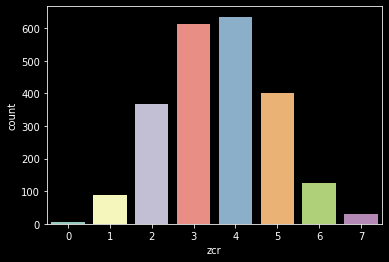

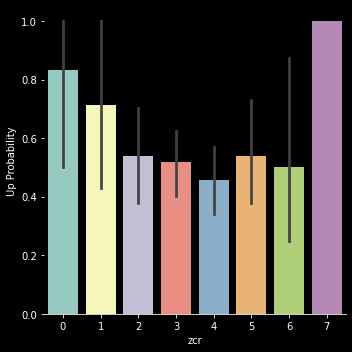

In [0]:
def zcr(data, days):
    yesterday = data.shift(1)
    yesterday[0] = yesterday[1]
    zc = np.abs(np.sign(data) - np.sign(yesterday)) // 2
    zcr = np.zeros(len(zc))
    zcr[0] = 0
    for i in range(1, days):
        zcr[i] = zcr[i-1] + zc[i]

    for i in range(days, len(data)):
        zcr[i] = zcr[i-1] + zc[i]
        zcr[i] = zcr[i]- zc[i - days]
        
    return zcr.astype(int)

for df in dfs:
    df['zcr'] = zcr(df['rdcp'], 7)

g = sns.countplot(x = 'zcr', data = dfs[0])

g = sns.catplot(x="zcr",y="ud",data=df,kind="bar")
g.despine(left=True)
g = g.set_ylabels("Up Probability")

這裡挑選了n=7來計算`Close Price`在n天內漲/跌變化的次數

## Close Price的漲跌連續變化次數


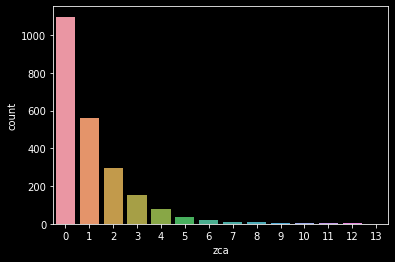

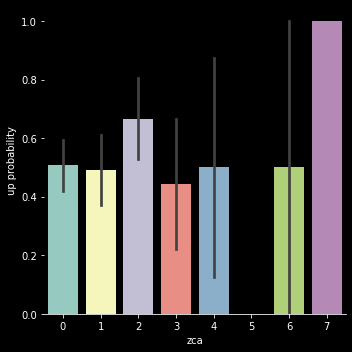

In [0]:
def zca(data):
    yesterday = data.shift(1)
    yesterday[0] = yesterday[1]
    zc = np.abs(np.sign(data) - np.sign(yesterday)) // 2
    zca = np.zeros(len(zc))
    zca[0] = 0
    for i in range(1, len(zc)):
        if zc[i] > 0:
            zca[i] = zca[i-1] + 1
        else:
            zca[i] = 0  
    return zca.astype(int)

for df in dfs:
    df['zca'] = zca(df['rdcp'])

g = sns.countplot(x = 'zca', data = dfs[0])

g = sns.catplot(x='zca',y='ud',data=df,kind="bar")
g.despine(left=True)
g = g.set_ylabels("up probability")

這是為計算下一項資料，因次沒有特別多做額外的處理

## Close Price的漲跌連續變化次數 && 當天漲或跌

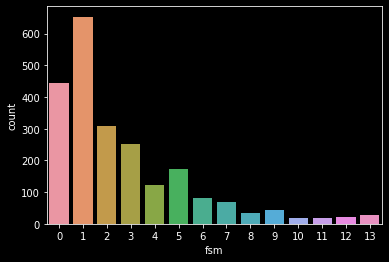

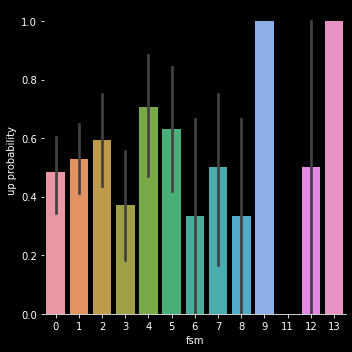

In [0]:
for df in dfs:
    df.loc[ df['zca'] > 6, 'zca'] = 6
    df['fsm'] = pn2bi(df['rdcp']) + df['zca'] * 2

g = sns.countplot(x = 'fsm', data = dfs[0])

g = sns.catplot(x='fsm',y='ud',data=df,kind="bar")
g.despine(left=True)
g = g.set_ylabels("up probability")

`Close Price`的漲跌連續變化次數配上當天漲或跌的情況(`rdcp`)，總共有13種情況

## Open Price與Close Price的差距

(array([3.000e+00, 5.000e+00, 2.300e+01, 1.130e+02, 4.110e+02, 1.223e+03,
        3.960e+02, 7.600e+01, 1.300e+01, 1.000e+00]),
 array([-79.02 , -64.342, -49.664, -34.986, -20.308,  -5.63 ,   9.048,
         23.726,  38.404,  53.082,  67.76 ]),
 <a list of 10 Patch objects>)

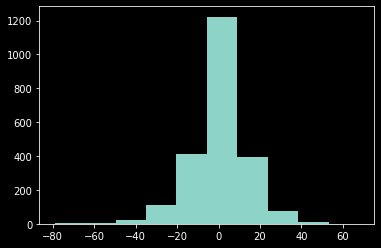

In [0]:
for df in dfs:
    df['roc'] = (df['Close Price'] - df['Open Price'])

plt.hist(dfs[0]['roc'])

用和前面一樣的方式取log處理

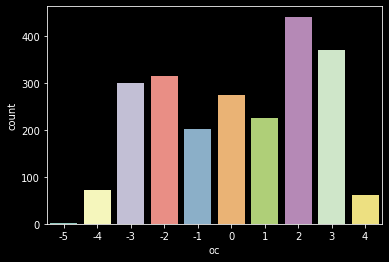

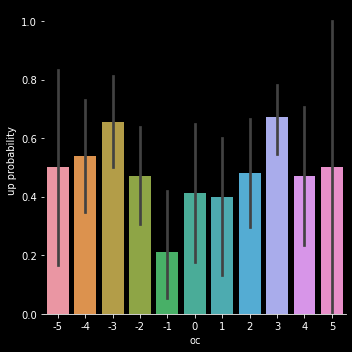

In [0]:
for df in dfs:
    df['oc'] = (df['roc'] * 2).apply(pnlog).astype(int)

g = sns.countplot(x = 'oc', data = dfs[0])

g = sns.catplot(x='oc',y='ud',data=df,kind="bar")
g.despine(left=True)
g = g.set_ylabels("up probability")

## 日期

<Figure size 432x288 with 0 Axes>

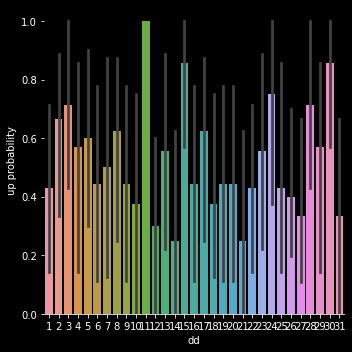

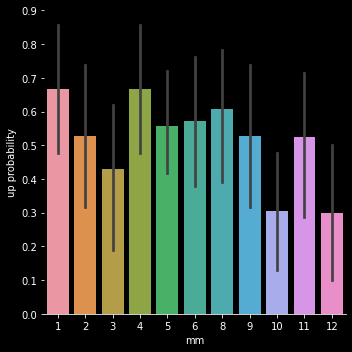

In [0]:
def get_day(date):
    return int(date[0:2])

def get_month(date):
    month = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':5, 'Jul':6, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}
    return month[date[3:6]]

for df in dfs:
    df['dd'] = df['Date'].apply(get_day)
    df['mm'] = df['Date'].apply(get_month)
    df['days'] = df['mm']*30 + df['dd']

plt.figure(1)
g = sns.catplot(x='dd',y='ud',data=df,kind="bar")
g.despine(left=True)
g = g.set_ylabels("up probability")

plt.figure(2)
g = sns.catplot(x='mm',y='ud',data=df,kind="bar")
g.despine(left=True)
g = g.set_ylabels("up probability")

這裡是處理將日期方為三個: 月份、幾號、以及當年第幾天

# 模型訓練

## 資料選擇

In [0]:
train_x = dfs[0][['fsm','sts','dcp','pre2','pre3','pre4','pre5','cup3','cdn3','acc14','zca','csu','csd']] # 0.5873015873015873 0.5952380952380952
ttrain_x = dfs[1][['fsm','sts','dcp','pre2','pre3','pre4','pre5','cup3','cdn3','acc14','zca','csu','csd']]

這裡選擇`fsm`, `sts`, `dcp`, `pre2`, `pre3`, `pre4`, `pre5`, `cup3`, `cdn3`,  `acc14`, `zca`, `csu`, `csd`作為training的資料

*   fsm: `Close Price`的漲跌連續變化次數 && 當天漲或跌
*   sts: `Close Price`前4天漲跌的排列方式
*   dcp, pre2, pre3, pre4, pre5: 今天的`Close Price`與n天前`Close Price`的差距， n = {1, 2, 3, 4, 5}
*   cup3, cdn3: `Close Price`在3天內漲/跌了幾次
*   acc14: `Close Price`在14天內平均漲/跌的幅度
*   zca: `Close Price`的漲跌連續變化次數
*   csu, csd: `Close Price`連續漲/跌的天數

## Logistic Regression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


training accuracy: 0.556095406360424
test accuracy: 0.5952380952380952


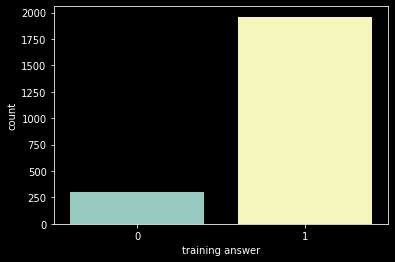

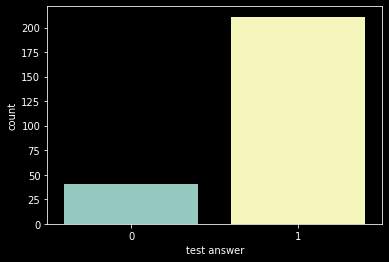

In [0]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

train_y = dfs[0]['ud']
    
model = LogisticRegression(
    penalty = 'l2',
    # penalty = 'elasticnet',
    C = 1e6,
    random_state = 1012,
    # fit_intercept = False,
    max_iter = 85,
    # warm_start = True,
    class_weight={0:0.51,1:0.5},
    # solver = 'saga',
    # intercept_scaling = 0.1,
    # l1_ratio = 0.1
)                      

model.fit(train_x, train_y)  
train_pred_y = model.predict(train_x)

train_acc = accuracy_score(train_pred_y, dfs[0]['ud'])
print(f'training accuracy: {train_acc}')
plt.figure(1)
plt.xlabel('training answer')
g = sns.countplot(train_pred_y)

pred_y = model.predict(ttrain_x)
train_acc = accuracy_score(pred_y, dfs[1]['ud'])
print(f'test accuracy: {train_acc}')
plt.figure(2)
plt.xlabel('test answer')
g = sns.countplot(pred_y)

### 模型參數

*   random_state = 1012
*   penalty = 'l2'
*   C = 1e6
*   max_iter = 85
*   class_weight = {0 : 0.51, 1 : 0.5}

這裡我故意把`max_iter`調低，雖然會跳出 `ConvergenceWarning: lbfgs failed to converge` 的warning，但test的結果反而變準。

這裡我把0的`class_weight`稍微調高0.01，accuracy比原本weight都一樣還高。再調更高accuracy又會降低了。




### 結果

模型大部分都猜1(漲)；`training accuracy` = 0.556095406360424，`test accuracy` = 0.5952380952380952；沒有overfitting的跡象。

## Neural Network

Epoch 1/25
2264/2264 [==============================] - 0s 124us/step - loss: 0.4296 - mae: 0.5481 - mse: 0.4296
Epoch 2/25
2264/2264 [==============================] - 0s 42us/step - loss: 0.2603 - mae: 0.4960 - mse: 0.2603
Epoch 3/25
2264/2264 [==============================] - 0s 40us/step - loss: 0.2562 - mae: 0.4947 - mse: 0.2562
Epoch 4/25
2264/2264 [==============================] - 0s 38us/step - loss: 0.2540 - mae: 0.4952 - mse: 0.2540
Epoch 5/25
2264/2264 [==============================] - 0s 40us/step - loss: 0.2504 - mae: 0.4928 - mse: 0.2504
Epoch 6/25
2264/2264 [==============================] - 0s 39us/step - loss: 0.2498 - mae: 0.4934 - mse: 0.2498
Epoch 7/25
2264/2264 [==============================] - 0s 35us/step - loss: 0.2495 - mae: 0.4927 - mse: 0.2495
Epoch 8/25
2264/2264 [==============================] - 0s 39us/step - loss: 0.2477 - mae: 0.4909 - mse: 0.2477
Epoch 9/25
2264/2264 [==============================] - 0s 38us/step - loss: 0.2491 - mae: 0.4941 - mse

(array([ 81.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 171.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

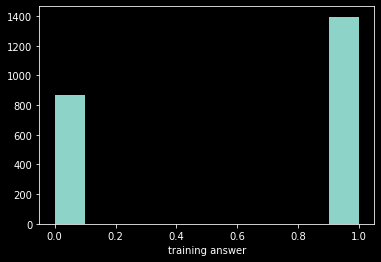

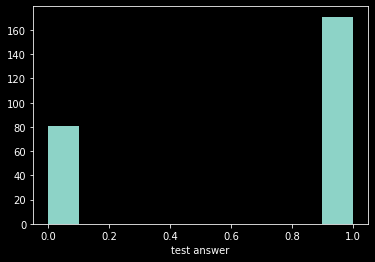

In [0]:
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Activation
from keras.optimizers import adam

model = Sequential()

model.add(Dense(units = 80, input_dim = train_x.shape[1]))
model.add(Activation("relu"))
model.add(Dense(units = 68))
model.add(Activation("relu"))
model.add(Dense(units = 47))
model.add(Activation("relu"))
model.add(Dense(units = 14))
model.add(Activation("relu"))
model.add(Dense(units = 1))
model.add(Activation("linear"))

model.compile(loss='mse', optimizer=adam(lr=0.01), metrics=['mae', 'mse'])
train_y = train_y.astype(int)
model.fit(train_x, train_y, epochs=25, batch_size=50)

train_pred_y = model.predict_classes(train_x)
train_acc = accuracy_score(train_y, train_pred_y.astype(int))
print(f'training accuracy: {train_acc}')
plt.figure(1)
plt.xlabel('training answer')
plt.hist(train_pred_y)

pred_y = model.predict_classes(ttrain_x)
train_acc = accuracy_score(pred_y.astype(int), dfs[1]['ud'])
print(f'test accuracy: {train_acc}')
plt.figure(2)
plt.xlabel('test answer')
plt.hist(pred_y)


### 模型參數

我已經努力試著找到一個深度, `epochs`, `batch_size`比較合適的數量了，但結果不是很理想

### 結果

模型沒有特別猜1或0，有時候訓練出來的模型猜1比較多，有時候猜0比較多，也有猜得很平均的

`training accuracy`大約落在0.55 ~ 0.65之間， `test accuracy`大約落在0.48 ~ 0.58之間，結果非常不穩定

train比test準了大約10%，稍微有overfitting的跡象。

## RandomForestClassifier

training accuracy: 0.5909893992932862
test accuracy: 0.5833333333333334


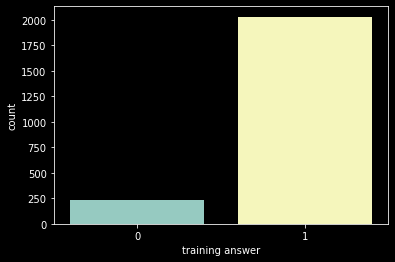

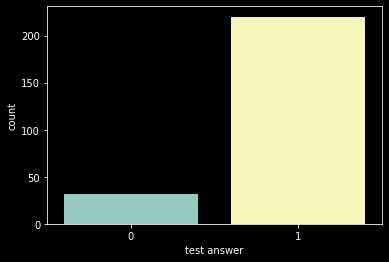

In [0]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators = 130,
    random_state = 1012,
    max_depth = 5,
    # max_leaf_nodes = 2 ** 10,
    min_samples_split = 4,
    # min_samples_leaf = 2,
    # max_features = 3,
    )  

model.fit(train_x, train_y)  
train_pred_y = model.predict(train_x)

train_acc = accuracy_score(train_pred_y, dfs[0]['ud'])
print(f'training accuracy: {train_acc}')
plt.figure(1)
plt.xlabel('training answer')
g = sns.countplot(train_pred_y)

pred_y = model.predict(ttrain_x)
train_acc = accuracy_score(pred_y, dfs[1]['ud'])
print(f'test accuracy: {train_acc}')
plt.figure(2)
plt.xlabel('test answer')
g = sns.countplot(pred_y)             

### 模型參數

*   random_state = 1012
*   n_estimators = 130
*   max_depth = 5
*   min_samples_split = 4

`max_depth`深於5就開始出現overfitting的現象，淺於5則會underfitting

`n_estimators`, `min_samples_split` 也都是慢慢試出來的結果

### 結果

模型大部分都猜1(漲)

`training accuracy` = 0.5909893992932862，`test accuracy` = 0.5833333333333334

train跟test的結果都還不錯，沒有overfitting的跡象。